### Imports

In [1]:
import pandas as pd
import numpy as np
import torch

### Load sequence data from cryptic seq experiment

In [3]:
import genome_utils
import genomepy

genomic_reference_file = '../data/references/hg38.fa'
vocab_size = 5
hidden_size = 46*5
train_test_split = 0.8

# Key for data label
label_key = ''

# Load cryptic sites
sites = pd.read_csv('./data/gt_cryptic.csv')
sites = genome_utils.fetch_genomic_sites(sites, genomic_reference_file)

hits = sites['sequence']
hit_count = len(hits)
if label_key == '':
    hits_labels = np.ones(len(sites))
else:
    hits_labels = sites[label_key]

# Length of a cryptic site
seq_length = len(hits[0])

# Generate random decoy sequences
genome = genomepy.genome.Genome(genomic_reference_file)
samples = genome.get_random_sequences(n=hit_count, length=seq_length-1, max_n=0)
decoys = pd.Series(list(map(lambda row: genome.get_seq(*row).seq.upper(), samples)))
decoys_labels = np.zeros(len(decoys))

# Set dinucleotide to NN in both hits and decoys
dn_start = int(seq_length/2)
hits = hits.apply(lambda seq: seq[:dn_start-1] + 'NN' + seq[dn_start+1:])
decoys = decoys.apply(lambda seq: seq[:dn_start-1] + 'NN' + seq[dn_start+1:])

# Concatenate hits and decoys
sequences = np.hstack([hits, decoys])
labels = np.hstack([hits_labels, decoys_labels])

In [4]:
from models import mlp
from datasets import one_hot

dataset = one_hot.Dataset(sequences, labels, vocab_size=vocab_size)
loss_fn = torch.nn.BCEWithLogitsLoss()


# Test and train data split
train_size = int(train_test_split*len(dataset))
test_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

# Build model
model = mlp.Model(input_size=seq_length*vocab_size, hidden_size=hidden_size, output_size=1, n_hidden=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training

In [5]:
from sklearn.metrics import f1_score, accuracy_score

epochs = 20

# training loop
for epoch in range(epochs):
    train_loss = 0.0
    train_preds, train_targets = [], []

    # Training Phase
    for i, (data, target) in enumerate(train_dataloader):
        output = model(data).flatten()

        # Convert output probabilities to predicted class
        preds = (output > 0.5).float()
        train_preds.extend(preds.tolist())
        train_targets.extend(target.tolist())

        loss = loss_fn(output, target.float())
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_accuracy = accuracy_score(train_targets, train_preds)
    train_f1 = f1_score(train_targets, train_preds, average='weighted')

    print(f"Epoch {epoch}/{epochs}")
    print(f"-------------")
    print(f"Train loss: {train_loss/len(train_dataloader)}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Train F1 Score: {train_f1}")

    val_loss = 0.0
    val_preds, val_targets = [], []

    # Validation Phase
    with torch.no_grad():
        for i, (data, target) in enumerate(val_dataloader):
            output = model(data).flatten()

            # Convert output probabilities to predicted class
            preds = (output > 0.5).float()
            val_preds.extend(preds.tolist())
            val_targets.extend(target.tolist())

            loss = loss_fn(output, target.float())
            val_loss += loss.item()

        val_accuracy = accuracy_score(val_targets, val_preds)
        val_f1 = f1_score(val_targets, val_preds, average='weighted')

    print(f"Val loss: {val_loss/len(val_dataloader)}")
    print(f"Val Accuracy: {val_accuracy}")
    print(f"Val F1 Score: {val_f1}")
    print(f"-------------\n")

tensor([1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
        1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.],
       dtype=torch.float64)
tensor([1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1.],
       dtype=torch.float64)
tensor([1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
        0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0.],
       dtype=torch.float64)
tensor([1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
        1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1.],
       dtype=torch.float64)
tensor([0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.],
       dtype=torch.float64)
tensor([0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0.,

### Analysis

INFO:matplotlib.font_manager:Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
INFO:matplotlib.font_manager:Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
INFO:matplotlib.font_manager:Failed to extract font properties from /System/Library/Fonts/LastResort.otf: tuple indices must be integers or slices, not str


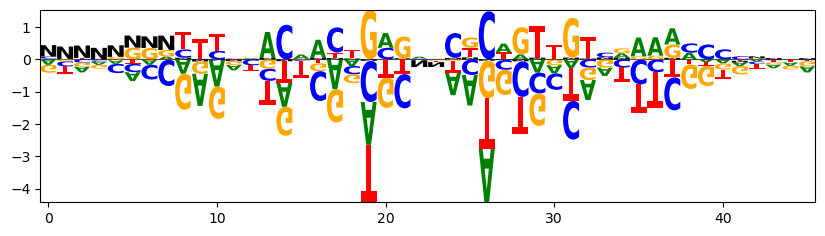

In [6]:
import logomaker
from matplotlib import pyplot as plt
prob_weight_matrix = pd.DataFrame(model.fc_layers[0].weight.detach().numpy().reshape(46,5), columns=['A','T','C','G','N'])
logomaker.Logo(prob_weight_matrix, color_scheme='classic')